![title](hintergrund.png)

![title](data.png)

# Vorhersagen mechanischer Fehlfunktion
## Einleitung
Die vorausschauende Wartung konzentriert sich auf die Vorhersage des Zeitpunkts eines
Gerätefehlers und die Verhinderung dieses Fehlers mithilfe der Wartungsüberwachung. So kann die
Wartung geplant werden, bevor sich ein Problem manifestiert. Eines der besonderen Merkmale der
vorausschauenden Wartung ist, dass die Wartungshäufigkeit ein absolutes Minimum darstellt und
dazu beiträgt, ungeplante reaktive Wartungsarbeiten und die mit der vorbeugenden Wartung
verbundenen Kosten zu vermeiden.

## Problemstellung
In diesem Beispeil, werden Sie anhand der gemessenen Daten der Windrädern vorhersagen, ob das Gerät
in der nächsten Woche ausfallen wird (wie unteres Bild gezeigt). Die Daten wurden durch ein Supervisory
Control And Data Acquisition (SCADA) System gesammelt. Um vielfältige Informationen zu sammeln, z.B.
Umgebungsinformationen (Temperatur, Feuchtigkeit), Gerätestatusinformationen (Strom,
Spannung, Vibration) und Parameterinformationen, wurden 75 Sensoren an den Geräten montiert.


Alle gesammelten Informationen sind in der folgenden Tabelle aufgeführt.

| Sensor Nr | Information | Sensor Nr | Information   | Sensor Nr | Information      |
|----------|:-----------------:|------------------:|------------------:|-----------------|------------------------------------|
| 1  |  Wheel speed   |               26 | Inverter inlet temperature |      51       |  Pitch motor 1 power estimation          |
| 2  |  hub angle     |               27 | inverter outlet temperature             |       52       |  Pitch motor 2 power estimation         |
| 3  |  blade 1 angle  |               28 | inverter inlet pressure |       53       |  Pitch motor 3 power estimation          |
| 4  |  blade 2 angle        |               29 | inverter outlet pressure             |    54          |   Fan current status value         |
| 5  |  blade 3 angle        |               30 | generator power limit value |     55        |     hub current status value       |
| 6  |  pitch motor 1 current        |               31 | reactive power set value             |     56         |   yaw state value         |
| 7  |  pitch motor 2 current        |               32 | Rated hub speed |      57        |    yaw request value        |
| 8  |  Pitch motor 3 current        |               33 | wind tower ambient temperature       |        58      |   blade 1 battery box temperature         |
| 9  |  overspeed sensor speed detection value |               34 | generator stator temperature 1 |        59      |  blade 2 battery box temperature          |
| 10 |  5 second yaw against wind average      |               35 | generator stator temperature 2             |      60        |   blade 3 battery box temperature         |
| 11 |  x direction vibration value   |               36 | generator stator temperature 3 |      61       |   vane 1 pitch motor temperature         |
| 12 |  y direction vibration value   |               37 | generator stator temperature 4             |      62        |  blade 2 pitch motor temperature          |
| 13 |  hydraulic brake pressure      |               38 | generator stator temperature 5 |      63        |     blade 3 pitch motor temperature       |
| 14 |  Aircraft weather station wind speed      |               39 | generator stator temperature 6             |      64        |    blade 1 inverter box temperature        |
| 15 |  wind direction absolute value        |               40 | generator air temperature 1 |      65        |    blade 2 inverter box temperature        |
| 16 |  atmospheric pressure        |               41 | generator air temperature 2             |      66        |    blade 3 inverter box temperature        |
| 17 |  reactive power control status        |               42 | main bearing temperature 1 |       67       |   blade 1 super capacitor voltage         |
| 18 |  inverter grid side current        |               43 | main bearing temperature 2             |      68        |    blade 2 super capacitor voltage        |
| 19 |  inverter grid side voltage        |               44 | Wheel temperature |      69        |    blade 3 super capacitor voltage        |
| 20 |  Inverter grid side active power        |               45 | Wheel control cabinet temperature             |      70       |   drive 1 thyristor temperature         |
| 21 |  inverter grid side reactive power        |               46 | Cabin temperature |      71       |   Drive 2 thyristor temperature         |
| 22 |  inverter generator side power        |               47 | Cabin control cabinet temperature             |      72        |            | Drive 3 thyristor temperature
| 23 |  generator operating frequency        |               48 | Inverter INU temperature|      73        |  Drive 1 output torque          |
| 24 |  generator current'        |               49 | Inverter ISU temperature             |      74        |    Drive 2 output torque        |
| 25 |  generator torque        |               50 | Inverter INU RMIO temperature             |      75        |     Drive 3 output torque       |

## Datenbeschreibung
Die Trainingsdatensätze werden in jeweils einer CSV-Datei gespeichert. Jede CSV-Datei enthält innerhalb von 4500 Minuten abgetastete Informationen. Das Label jeder CSV gibt an, ob der windrad innerhalb der nächsten Woche eine Fehlfunktion aufweist. Entsprechende Labelsinformationen finden Sie in Datei train_label.csv. Das Inhaltsformat von train_label.csv ist wie folgt:

| ID                                         | Label | 
|----------|:-----------------|
| 01725e06-98ea-3447-83c0-b3aa70feff62.csv   |       0        |   
| 02c2cada-dbbe-304b-95b2-076ddba766c9.csv   |        1       |     

**0**: Das entsprechende Gerät ist innerhalb der nächsten Woche nicht ausgefallen

**1**: Das entsprechende Gerät ist innerhalb der nächsten Woche ausgefallen

# Import

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd

from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

# Parameter optimization
from skopt.space import Integer, Real, Categorical, Identity
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Model
from sklearn import svm
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

# Exploration

In [5]:
Data_frame = pd.read_csv("data/train/004/0000f25f-4d58-3eee-bbc3-5c7b7759ee66.csv")
Data_frame.head()

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,...,blade 3 inverter box temperature,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque
0,0.14,47.74,21.0,21.0,21.0,2.12,2.16,3.08,0.16,-59.4,...,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.08,159.52,21.0,21.0,21.0,2.62,1.70,3.14,1.12,-69.8,...,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.30,241.24,21.0,21.0,21.0,2.26,1.50,3.02,1.35,31.4,...,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.68,355.50,21.0,21.0,21.0,2.54,2.42,3.22,0.74,-1.8,...,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.51,155.02,21.0,21.0,21.0,2.44,1.58,2.92,0.52,-41.2,...,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


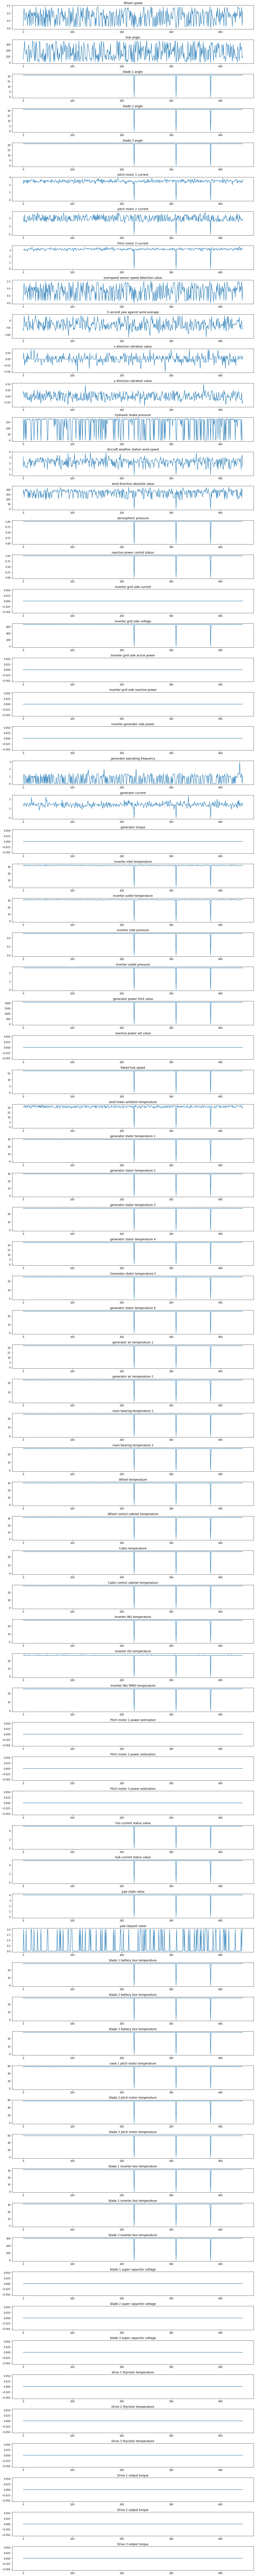

In [6]:
# Visualization / 
numberOfcolumns = Data_frame.shape[1]
col = Data_frame.columns
plt.figure(figsize=(15,150))
for v in range(numberOfcolumns):
    a = plt.subplot(numberOfcolumns, 1, v+1)
    a.plot(Data_frame.index.values, Data_frame.iloc[:,v].values)
    a.title.set_text(col[v])
    plt.tight_layout()
plt.show()

# Feature Engineering und Auswahl

### Feature Engineering

In [7]:
TRAIN_LABEL_PATH = "data/train_label.csv"
TEST_LABEL_PATH = "data/test_label.csv"
TRAIN_PATH = "data/train/"
TEST_PATH = "data/test/"

# label dataframe 
label = pd.read_csv(TRAIN_LABEL_PATH)

def get_feature(args):
    _file_path = args
    _df = pd.read_csv(_file_path)
    _file_name = _file_path.split('/')[-1]
    _dict_return = {}
    _dict_return[_file_name] = []
    
    # Extracting the feature MEAN from the time series as a feature
    mean_feature = np.mean(_df).values
    for value in mean_feature:
        _dict_return[_file_name].append(value)

    # What other features can be extracted from the time series ??
    
    
    return _dict_return


In [8]:
# extract features from train (time series)
dict_result = {}
for f1 in tqdm(os.listdir(TRAIN_PATH)):
    dict_temp = []
    nargs = os.listdir(TRAIN_PATH + f1)
    nargs = [(TRAIN_PATH + f1 + '/' + _i) for _i in nargs]
    for item in nargs:
        dict_temp.append(get_feature(item))
    for item in dict_temp:
        dict_result.update(item)
        
train = pd.DataFrame(dict_result)
# train.head()
train = train.T
train['file_name'] = train.index
train = train.reset_index(drop=True)

train = pd.merge(train, label[['file_name', 'ret']], on='file_name', how='left')
train = train.reset_index(drop=True)

del train["file_name"]


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [08:59<00:00, 31.76s/it]


In [1]:
train["ret"].isna().values.sum()

NameError: name 'train' is not defined

#### Merkmalsauswahl


In [6]:
# Merkmalsauswahl




In [26]:
# extract selected features from test (time series)

label = pd.read_csv(TEST_LABEL_PATH)
dict_result = {}

for f1 in tqdm(os.listdir(TEST_PATH)):
    dict_temp = []
    nargs = os.listdir(TEST_PATH+f1)
    nargs = [(TEST_PATH + f1 + '/'+ _i) for _i in nargs]
    for item in nargs:
        dict_temp.append(get_feature(item))
    for item in dict_temp:
        dict_result.update(item)

test = pd.DataFrame(dict_result)

test = test.T
test['file_name'] = test.index
test = test.reset_index(drop=True)

test = pd.merge(test, label[['file_name', 'ret']], on='file_name', how='left')
test = test.reset_index(drop=True)

del test["file_name"]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:34<00:00, 39.22s/it]


In [40]:
test["ret"].isna().values.sum()

1308

In [43]:
# drop missing label in test 
test= test.dropna()

In [44]:
x_train = train.iloc[:,:-1].get_values()
y_train = train.iloc[:,-1].get_values()
x_test = test.iloc[:,:-1].get_values()
y_test = test.iloc[:,-1].get_values()

# Modellauswahl und Konfigurationsoptimierung

## base line
what is the baseline?
## Bewertungsmetrik 
What is the evaluation metric?

In [45]:
base_line_test = np.zeros_like(y_test)+1
f1 = f1_score(y_test, base_line_test)
print("The f1 score of test dataset is ", f1)

The f1 score of test dataset is  0.6611245195315992


## Model Optimization : take svm as an example

In [ ]:
# Modellkandidaten können sein: SVM, Lineares Modell, Logitisches Modell, KNN, Xgboost, LightGBM .....


# Neben GridSearch, Es gibt auch andere Hyperparameter-Optimierungspakete wie Skopt.gp_minimize , SMAC , Hyperopt, SMAC with Hyperband
# https://automl.github.io/SMAC3/master/examples/hyperband_mlp.html


# Oder Automated Machine Learning
# wie Auto-Sklearn oder TPOT.

# Result presentation

In [9]:
# Wenn das Ergebnis nicht gut ist, versuchen Sie, die Ursache zu analysieren. 
# nutzen Sie die Hinweise 
# -Data drift
# -Concept drift
# -cross domain feature learning
# -cross domain transfer learning
